Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Image Classification Using Scikit-learn

## Prerequisites

*    [ A Kubernetes cluster deployed on Azure Stack HCI, connected to Azure through ARC](https://docs.microsoft.com/en-us/azure-stack/aks-hci/connect-to-arc).
     

*    [ Setup a NFS Server ](https://github.com/Azure/AML-Kubernetes/blob/master/docs/setup-ephemeral-nfs-volume.md) 


*    Last but not least, you need to be able to run a Notebook. (azureml-core, azureml-opendatasets, numpy, matplotlib, requests are required)

   If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the configuration Notebook located at [here](https://github.com/Azure/MachineLearningNotebooks) first. This sets you up with a working config file that has information on your workspace, subscription id, etc.

## Initialize AzureML workspace

Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`. 

If you haven't done already please go to `config.json` file and fill in your workspace information.

In [1]:
from azureml.core.workspace import Workspace,  ComputeTarget
from azureml.exceptions import ComputeTargetException

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: amlarc-sample-test-ws-eastus
Azure region: eastus
Subscription id: 86204643-5a96-427b-b6bb-b35b2bd6e6ce
Resource group: AKS-HCI2


## Download mnist data

Perform pip install azureml-opendatasets to get the open dataset package, use this function to download mnist data later. This allows you to avoid download the data again when you run this notebook multiple times. The actual download time may take 2 minutes.

In [2]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST
import os

def download_mnist_data():
    data_folder = os.path.join(os.getcwd(), 'mnist_data')
    os.makedirs(data_folder, exist_ok=True)

    mnist_file_dataset = MNIST.get_file_dataset()
    path = mnist_file_dataset.download(data_folder, overwrite=True)
    downloaded_folder = os.path.dirname(path[0])
    print("downloaded to", downloaded_folder)
    
    return downloaded_folder

downloaded_folder = download_mnist_data()
downloaded_folder


downloaded to /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/mnist_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist


'/home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/mnist_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist'

## Prepare the mnist data to NFS server

The above download_mnist_data() function will download four files t10k-images-idx3-ubyte.gz, t10k-labels-idx1-ubyte.gz, train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz to downloaded_folder.  Your next step is to copy these files to NFS server.

In [3]:
nfs_mount_path = "/home/jiadu/data"

import os, shutil
mnist_dir = os.path.join(nfs_mount_path, 'mnist')
shutil.rmtree(mnist_dir, ignore_errors=True)
os.makedirs(mnist_dir, exist_ok=True)


In [4]:
for filename in os.listdir(downloaded_folder):
    filepath = os.path.join(downloaded_folder, filename)
    destpath = os.path.join(mnist_dir, filename)
    print(f"Copying files from {filepath} to {destpath}")
    shutil.copyfile(filepath, destpath)

Copying files from /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/mnist_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz to /home/jiadu/data/mnist/train-labels-idx1-ubyte.gz
Copying files from /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/mnist_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz to /home/jiadu/data/mnist/t10k-labels-idx1-ubyte.gz
Copying files from /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/mnist_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz to /home/jiadu/data/mnist/train-images-idx3-ubyte.gz
Copying files from /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/mnist_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz to /home/jiadu/data/mnist/t10k-images-idx3-ubyte.gz


## Setup compute target

Find the Arc K8S Resource Id, e.g. /subscriptions/86204643-5a96-427b-b6bb-b35b2bd6e6ce/resourceGroups/AKS-HCI2/providers/Microsoft.Kubernetes/connectedClusters/my-workload-cluster and replace the resource id below.

Using 'kubectl create ns aml' to create a namespace in advance.

In [6]:
from azureml.core.compute import KubernetesCompute
from azureml.core.compute import ComputeTarget
import os

ws = Workspace.from_config()

# choose a name for your Azure Arc-enabled Kubernetes compute
amlarc_compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "amlarc-compute")

# resource ID for your Azure Arc-enabled Kubernetes cluster
resource_id = "/subscriptions/86204643-5a96-427b-b6bb-b35b2bd6e6ce/resourceGroups/AKS-HCI2/providers/Microsoft.Kubernetes/connectedClusters/my-workload-cluster"

if amlarc_compute_name in ws.compute_targets:
   amlarc_compute = ws.compute_targets[amlarc_compute_name]
   if amlarc_compute and type(amlarc_compute) is KubernetesCompute:
      print("found compute target: " + amlarc_compute_name)
else:
   print("creating new compute target...")
   ns = "aml"
    
   instance_types = {
    "defaultInstanceType": {
      "nodeSelector": None,
      "resources": {
        "requests": {
          "cpu": "1",
          "memory": "4Gi",
          "nvidia.com/gpu": 0
        },
        "limits": {
          "cpu": "1",
          "memory": "4Gi",
          "nvidia.com/gpu": 0
        }
      }
    }
  }

   amlarc_attach_configuration = KubernetesCompute.attach_configuration(resource_id = resource_id, namespace = ns, default_instance_type="defaultInstanceType", instance_types = instance_types)
 
   amlarc_compute = ComputeTarget.attach(ws, amlarc_compute_name, amlarc_attach_configuration)

 
   amlarc_compute.wait_for_completion(show_output=True)
    
   # For a more detailed view of current KubernetesCompute status, use get_status()
   print(amlarc_compute.get_status().serialize())

print(f"compute target id in endpoint yaml: azureml:{amlarc_compute.name}")

Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


found compute target: amlarc-compute
compute target id in endpoint yaml: azureml:amlarc-compute


In [7]:
from azureml.core.compute import KubernetesCompute

attach_name = amlarc_compute_name
arcK_target = KubernetesCompute(ws, attach_name)

Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


## Setting up an NFS Server on AML Arc

[ How to setup an NFS server on AML Arc ](https://github.com/Azure/AML-Kubernetes/tree/master/examples/train-using-nfs/amlarc-nfs-setup)

kubectl apply -f docs/AKS-HCI/notebooks/nfs/mount-config.yaml

Note, need to modify path and server accordingly. 

Use: kubectl get cm mount-config -n azureml -o yaml to verify the configuration

## Configure the training job and submit

### Create an experiement

In [8]:
from azureml.core import Experiment

experiment_name = 'mnist-demo'

exp = Experiment(workspace=ws, name=experiment_name)

### Create an environment

In [ ]:
# use a curated environment that has already been built for you

# from azureml.core.environment import Environment
# env = Environment.get(workspace=ws, 
#                       name="AzureML-Scikit-learn0.24-Cuda11-OpenMpi4.1.0-py36", 
#                       version=1)

In [9]:
# customized environment

from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

### Configure the training job

The training takes about 15 mins with vm size comparable  to Standard_DS3_v2, /nfs_share is the same as the mountPath defined in mount-config.yaml.

In [23]:
from azureml.core import ScriptRunConfig

data_folder = os.path.join("/nfs_share", "mnist") # training data are saved to <mountPoint>/mnist

args = ['--data-folder', data_folder, '--regularization', 0.5]
script_folder =  "mnist_script"
src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=arcK_target,
                      environment=env)

### Submit the job

Run your experiment by submitting your ScriptRunConfig object. Note that this call is asynchronous.

In [22]:
run = exp.submit(config=src)
run.wait_for_completion(show_output=True)  # specify True for a verbose log

RunId: mnist-demo_1632392696_7b80f14f
Web View: https://ml.azure.com/runs/mnist-demo_1632392696_7b80f14f?wsid=/subscriptions/86204643-5a96-427b-b6bb-b35b2bd6e6ce/resourcegroups/AKS-HCI2/workspaces/amlarc-sample-test-ws-eastus&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Streaming azureml-logs/75_job_post-tvmps_aae64d6b3c867d5fa7760a4e2fa1c9d7-master-0_d.txt

[2021-09-23T10:28:02.700916] Entering job release
Cannot provide tracer without any exporter configured.
[2021-09-23T10:28:03.600841] Starting job release
[2021-09-23T10:28:03.601185] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 785
[2021-09-23T10:28:03.601817] job release stage : upload_datastore starting...
[2021-09-23T10:28:03.602056] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-09-23T10:28:03.602419] job release stage : copy_batchai_cached_logs starting...
[2021-09-23T10:28:03.609978] job rel

{'runId': 'mnist-demo_1632392696_7b80f14f',
 'target': 'amlarc-compute',
 'status': 'Completed',
 'startTimeUtc': '2021-09-23T10:26:00.195237Z',
 'endTimeUtc': '2021-09-23T10:30:55.640603Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'kubernetes',
  'ContentSnapshotId': '5934cc11-9af1-4771-9df9-8c3688e1cd20',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'azureml.git.repository_uri': 'https://github.com/msftcoderdjw/AML-Kubernetes.git',
  'mlflow.source.git.repoURL': 'https://github.com/msftcoderdjw/AML-Kubernetes.git',
  'azureml.git.branch': 'private/jiadu/ignite',
  'mlflow.source.git.branch': 'private/jiadu/ignite',
  'azureml.git.commit': '994357186e696071834f1c0684cc2b0e0877bef5',
  'mlflow.source.git.commit': '994357186e696071834f1c0684cc2b0e0877bef5',
  'azureml.git.dirty': 'False',
  'JobType': 'RegularJob',
  'GpuCount': '0',
  'Cluster': 'my-workload-cluster'},
 'inputDatasets': [],
 'o

### Register the model

Register the trained model.

In [12]:
model_name='sklearn_mnist'

In [13]:
# register model
model = run.register_model(model_name=model_name,
                           model_path='outputs/sklearn_mnist_model.pkl')

The machine learning model named "sklearn_mnist" should be registered in your AzureML workspace.

### Get the model

In [14]:
from azureml.core.model import Model
model = Model(ws, model_name)
model_id = f"azureml:{model.name}:{model.version}"
print(f"Get {model.name}, latest version {model.version}, id in endpoint.yml: {model_id}")

Get sklearn_mnist, latest version 1, id in endpoint.yml: azureml:sklearn_mnist:1


## Deploy and score a machine learning model by using a managed online endpoint

AZ CLI only now

In [15]:
endpoint = 'sklearn-mnist-jiadu'

import os
from pathlib import Path
prefix = Path(os.getcwd())
endpoint_file = str(prefix.joinpath("endpoint.yml"))
print(f"Using Endpoint file: {endpoint_file}, please replace model id (e.g. azureml:sklearn_mnist:2) and compute target id (e.g. azureml:amlarc-compute4) according above output")

Using Endpoint file: /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/endpoint.yml, please replace model id (e.g. azureml:sklearn_mnist:2) and compute target id (e.g. azureml:amlarc-compute4) according above output


In [17]:
import helpers
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')
helpers.run(f"az ml endpoint create -n {endpoint} -f {endpoint_file} -w {ws.name} -g {ws.resource_group}")

Workspace name: amlarc-sample-test-ws-eastus
Azure region: eastus
Subscription id: 86204643-5a96-427b-b6bb-b35b2bd6e6ce
Resource group: AKS-HCI2
START: az ml endpoint create -n sklearn-mnist-jiadu -f /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist/endpoint.yml -w amlarc-sample-test-ws-eastus -g AKS-HCI2 @ 2021-09-23 18:04:43 (2021-09-23 10:04:43 UTC)
       using: /usr/bin/az (Linux 5.4.0-84-generic on x86_64)
       cwd: /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist
STDERR: WARNING: Command group 'ml endpoint' is experimental and under development. Reference and support levels: https://aka.ms/CLI_refstatus
Uploading mnist:   0%|          | 0.00/11.7M [00:52<?, ?B/s]
STDERR: The deployment request amlarc-sample-test-ws-eastus-sklearn-mnist-jiadu-6633972 was accepted. ARM deployment URI for reference: 
STDERR: https://ms.portal.azure.com/#blade/HubsExtension/DeploymentDetailsBlade/overview/id/%2Fsubscriptions%2F86204643-5a96-427b-b6bb-b35b2bd6e6ce%2FresourceGro

## Test training model

### Test with inputs

Here you may use the image from test asset. The first 30 images and its labels are shown below.

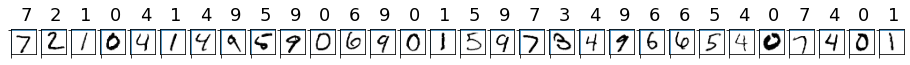

In [18]:
from mnist_script.utils import load_data
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

data_folder = os.path.join(os.getcwd(), 'mnist_data')

X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

# show first 30 figures

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
# for i in np.random.permutation(X_test.shape[0])[:sample_size]:
for i in range(30):
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_test[i], fontsize = 18)
    plt.imshow(X_test[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

Get score_uri and access_token from AZ CLI (Currently only AZ CLI supported)

In [19]:
# get predicted digits:
import helpers
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
cmd = f"az ml endpoint show -n {endpoint} -w {ws.name} -g {ws.resource_group}"
properties = helpers.run(cmd, return_output=True, no_output=True)

cmd = f"az ml endpoint get-credentials -n {endpoint} -w {ws.name} -g {ws.resource_group}"
credentials = helpers.run(cmd, return_output=True, no_output=True)

START: az ml endpoint show -n sklearn-mnist-jiadu -w amlarc-sample-test-ws-eastus -g AKS-HCI2 @ 2021-09-23 18:22:36 (2021-09-23 10:22:36 UTC)
       using: /usr/bin/az (Linux 5.4.0-84-generic on x86_64)
       cwd: /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist
START: az ml endpoint get-credentials -n sklearn-mnist-jiadu -w amlarc-sample-test-ws-eastus -g AKS-HCI2 @ 2021-09-23 18:22:40 (2021-09-23 10:22:40 UTC)
       using: /usr/bin/az (Linux 5.4.0-84-generic on x86_64)
       cwd: /home/jiadu/git/AML-Kubernetes/docs/AKS-HCI/notebooks/mnist


Test the second image: 2

In [20]:
import json
prop_response = json.loads(properties.replace(os.linesep,""))
score_uri = prop_response["scoring_uri"]

cred_response = json.loads(credentials.replace(os.linesep, ""))
access_token = cred_response["accessToken"]

import requests
# second number should be 2
test = json.dumps({"data": X_test.tolist()[1:2]})
headers = {'Content-Type': 'application/json', 'Authorization': f"Bearer {access_token}"}
r = requests.post(score_uri, data=test, headers=headers)
print(f"predictions: {r.content}")

predictions: b'[2]'


## Next steps

1. Learn how to [distributed training with pytorch](../distributed-cifar10/distributed-pytorch-cifar10.ipynb)
2. Learn how to [distributed training with tensorflow](../distributed-cifar10/distributed-tf2-cifar10.ipynb)
3. Learn Pipeline Steps with [Object Segmentation](../object-segmentation-on-azure-stack/)